### [예제 1] One-Hot Encoding 방식으로 구현된 Diabetes Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# 수치미분 함수

def numerical_derivative(f, x):
    delta_x = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    
    while not it.finished:
        idx = it.multi_index        
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + delta_x
        fx1 = f(x) # f(x+delta_x)
        
        x[idx] = float(tmp_val) - delta_x 
        fx2 = f(x) # f(x-delta_x)
        grad[idx] = (fx1 - fx2) / (2*delta_x)
        
        x[idx] = tmp_val 
        it.iternext()   
        
    return grad

# sigmoid 함수

def sigmoid(x):
    return 1 / (1+np.exp(-x))

#### One-Hot Encoding 방식으로 구현된 Diabetes class 구현

In [3]:
# Diabetes Class

class Diabetes:
    
    # 생성자
    # xdata, tdata => numpy.array(...)
    def __init__(self, name, input_nodes, hidden1_nodes, output_nodes, learning_rate):
        
        self.name = name
        
        # 2층 hidden layer unit 
        # 가중치 W, 바이어스 b 초기화
        self.W2 = np.random.rand(input_nodes, hidden1_nodes)  
        self.b2 = np.random.rand(hidden1_nodes)
        
        # 3층 hidden layer unit  
        self.W3 = np.random.rand(hidden1_nodes, output_nodes)
        self.b3 = np.random.rand(output_nodes)
        
        # 학습률 learning rate 초기화
        self.learning_rate = learning_rate
        
        print(self.name, " is created !!!")
        
    # 손실함수
    def feed_forward(self):
        
        delta = 1e-7    # log 무한대 발산 방지
    
        z2 = np.dot(self.input_data, self.W2) + self.b2
        a2 = sigmoid(z2)
        
        z3 = np.dot(a2, self.W3) + self.b3
        y = a3 = sigmoid(z3)
    
        # cross-entropy 
        return  -np.sum( self.target_data*np.log(y + delta) + (1-self.target_data)*np.log((1 - y)+delta ) )
    
    # 손실 값 계산
    def loss_val(self):
        
        delta = 1e-7    # log 무한대 발산 방지
    
        z2 = np.dot(self.input_data, self.W2) + self.b2
        a2 = sigmoid(z2)
        
        z3 = np.dot(a2, self.W3) + self.b3
        y = a3 = sigmoid(z3)
            
        # cross-entropy 
        return  -np.sum( self.target_data*np.log(y + delta) + (1-self.target_data)*np.log((1 - y)+delta ) )
    
    # query, 즉 미래 값 예측 함수
    def predict(self, input_data):    
        
        z2 = np.dot(input_data, self.W2) + self.b2
        a2 = sigmoid(z2)
        
        z3 = np.dot(a2, self.W3) + self.b3
        y = a3 = sigmoid(z3)
        
        # one-hot encoding 방식으로 하기 위한 코드 수정
        predicted_num = np.argmax(y)
    
        return predicted_num
    
    def accuracy(self, input_data, target_data):
        
        matched_list = []
        not_matched_list = []
        
        for index in range(len(input_data)):
            
            # one-hot encoding 방식으로 하기 위한 코드 수정
            label = int(target_data[index])
            
            predicted_num = self.predict(input_data[index])
            
            if predicted_num == label:
                matched_list.append(index)
            else:
                not_matched_list.append(index)
                
        accuracy_val = len(matched_list) / len(input_data)
        
        return accuracy_val
        
        
    # 수치미분을 이용하여 손실함수가 최소가 될때 까지 학습하는 함수
    def train(self, input_data, target_data):
        
        self.input_data = input_data
        self.target_data = target_data
        
        f = lambda x : self.feed_forward()
        
        self.W2 -= self.learning_rate * numerical_derivative(f, self.W2)
    
        self.b2 -= self.learning_rate * numerical_derivative(f, self.b2)
        
        self.W3 -= self.learning_rate * numerical_derivative(f, self.W3)
    
        self.b3 -= self.learning_rate * numerical_derivative(f, self.b3)

#### DataGeneration class 구현

In [4]:
class DataGeneration:
    
    # target_position = 0 (첫번째열이 정답데이터), target_position=-1 (마지막열이 정답데이터)
    def __init__(self, name, file_path, seperation_rate, target_position=-1):
        
        self.name = name
        
        self.file_path = file_path
        
        self.seperation_rate = seperation_rate
        
        if (target_position == -1  or  target_position == 0):      
            self.target_position = target_position
        
        else:
            err_str = 'target_position must be -1 or 0'            
            raise Exception(err_str)    
            
    
    # print data target distribution 
    # str_of_kind : 'original data' or  'training data'  or  'test data'
    def __display_target_distribution(self, data, str_of_kind='original data'):
        
        print('=======================================================================================================')
        
        target_data = data[ :, self.target_position ]
        
        # numpy.unique() 사용하여 loaded data target 분포 확인
        unique, counts = np.unique(target_data, return_counts=True)

        unique_target = []
    
        for index in range(len(unique)):
        
            print('[DataGeneration] unique number of ' + str_of_kind + ' = ', unique[index], ', count = ', counts[index])
        
            unique_target.append(unique[index])

        for index in range(len(unique_target)):
        
            print('[DataGeneration] unique number of ' + str_of_kind + ' = ', unique_target[index], ', ratio = ', np.round(100 * counts[index] / (target_data.shape[0]), 2), ' %')
    
        print('=======================================================================================================')
        
        
    # numpy.random.shuffle()  이용하여 training_data / test_data 생성
    def generate(self):
    
        # 데이터 불러오기, 파일이 없는 경우 exception 발생

        try:
            loaded_data = np.loadtxt(self.file_path, delimiter=',', dtype=np.float32)
            
        except Exception as err:
            print('[DataGeneration::generate()]  ', str(err))
            raise Exception(str(err))

        print("[DataGeneration]  loaded_data.shape = ", loaded_data.shape)
            
        # print the target distribution of original data 
        
        self.__display_target_distribution(loaded_data, 'original data')
        
        
        # 분리비율에 맞게 테스트데이터로 분리
        total_data_num = len(loaded_data)
        test_data_num = int(len(loaded_data) * self.seperation_rate)

        # numpy.random.shuffle 을 이용하여 랜덤하게 데이터 섞기
        np.random.shuffle(loaded_data)
        
        # test_data 는 0 : test_data_num
        
        
        test_data = loaded_data[ 0:test_data_num ]

        # training_data 는 test_data_num 부터 끝까지 
        training_data = loaded_data[ test_data_num: ]

        # display target distribution of generated data 
        
        self.__display_target_distribution(training_data, 'training data')
        
        self.__display_target_distribution(test_data, 'test data')
        
        return training_data, test_data

### (분리비율 0.3)  DataGeneration 객체를 통한 training_data , test_data

In [5]:
# DataGeneration 객체 생성.
test_seperation_rate = 0.3 # 테스트 데이터 분리비율

try:
    
    data_obj = DataGeneration('Diabetes', './diabetes.csv', test_seperation_rate)

    (training_data, test_data) = data_obj.generate()

    print('================================================')
    print('training data.shape = ', training_data.shape)
    print('test data.shape = ', test_data.shape)
    print('================================================')

except Exception as err:
    
    print('Exception occur !!')

[DataGeneration]  loaded_data.shape =  (759, 9)
[DataGeneration] unique number of original data =  0.0 , count =  263
[DataGeneration] unique number of original data =  1.0 , count =  496
[DataGeneration] unique number of original data =  0.0 , ratio =  34.65  %
[DataGeneration] unique number of original data =  1.0 , ratio =  65.35  %
[DataGeneration] unique number of training data =  0.0 , count =  188
[DataGeneration] unique number of training data =  1.0 , count =  344
[DataGeneration] unique number of training data =  0.0 , ratio =  35.34  %
[DataGeneration] unique number of training data =  1.0 , ratio =  64.66  %
[DataGeneration] unique number of test data =  0.0 , count =  75
[DataGeneration] unique number of test data =  1.0 , count =  152
[DataGeneration] unique number of test data =  0.0 , ratio =  33.04  %
[DataGeneration] unique number of test data =  1.0 , ratio =  66.96  %
training data.shape =  (532, 9)
test data.shape =  (227, 9)


#### Diabetes 객체 생성 및 학습 (One-Hot Encoding 방식으로 표현)

In [6]:
#hyper-parameter
i_nodes = training_data.shape[1] - 1    # input nodes 개수
h1_nodes = 30  # hidden 1 nodes 개수. 

o_nodes = 2    # one-hot encoding 표현하기 위한 output nodes 개수는 2개. 즉 정답은 0 또는 1 두개만 있음

lr = 1e-2      # learning rate. hi_node = 2, 1e-1 에서 수렴
epochs = 20   # 반복횟수. 

# 저장 리스트
loss_val_list = []    # loss val list
accuracy_val_list = []    # training data accuracy val
validation_accuracy_val_list = []    # validation data loss val


# Diabetes 객체 생성
obj1 = Diabetes("Diabetes", i_nodes, h1_nodes, o_nodes, lr)

print("Neural Network Learning using Numerical Derivative...")

start_time = datetime.now()

for step in range(epochs):
    
    for index in range(len(training_data)):
        
        input_data = training_data[index, 0:-1]
        
        # one-hot encoding 방식으로 표현                
        target_data = np.zeros(o_nodes) + 0.01    
        target_data[int(training_data[index, -1])] = 0.99
        
        obj1.train(input_data, target_data)
        
    # epochs 마다 validation 검증
    
    cur_loss_val = obj1.loss_val()    
    loss_val_list.append(cur_loss_val)
    
    training_accuracy = obj1.accuracy(training_data[:, 0:-1], training_data[:, -1])
    
    validation_accuracy = obj1.accuracy(test_data[:, 0:-1], test_data[:, -1])
    
    print('====================================================================')
    print("step = ", step, "            current loss value = ", cur_loss_val, '\n')
    print("step = ", step, "[training data] accuracy value = ", np.round(100*training_accuracy,4), ' %')
    
    accuracy_val_list.append(training_accuracy)
    
    print("step = ", step, "[validation data] accuracy value = ", np.round(100*validation_accuracy,4), ' %')
    
    validation_accuracy_val_list.append(validation_accuracy)

    print('====================================================================')

end_time = datetime.now()
        
print("")
print("Elapsed Time => ", end_time - start_time)

Diabetes  is created !!!
Neural Network Learning using Numerical Derivative...
step =  0             current loss value =  1.0562620960517255 

step =  0 [training data] accuracy value =  64.6617  %
step =  0 [validation data] accuracy value =  66.9604  %
step =  1             current loss value =  0.9030067910361023 

step =  1 [training data] accuracy value =  66.3534  %
step =  1 [validation data] accuracy value =  70.4846  %
step =  2             current loss value =  0.7855793102246529 

step =  2 [training data] accuracy value =  68.609  %
step =  2 [validation data] accuracy value =  72.6872  %
step =  3             current loss value =  0.6952697249977674 

step =  3 [training data] accuracy value =  69.7368  %
step =  3 [validation data] accuracy value =  74.8899  %
step =  4             current loss value =  0.6246724205336256 

step =  4 [training data] accuracy value =  71.4286  %
step =  4 [validation data] accuracy value =  75.7709  %
step =  5             current loss va

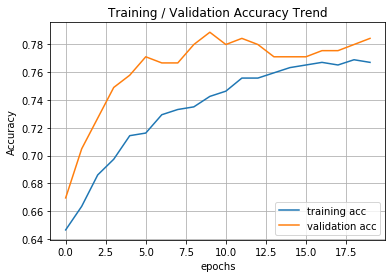

In [7]:
plt.title('Training / Validation Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.plot(accuracy_val_list, label='training acc')
plt.plot(validation_accuracy_val_list, label='validation acc')
plt.legend(loc='best')

plt.show()

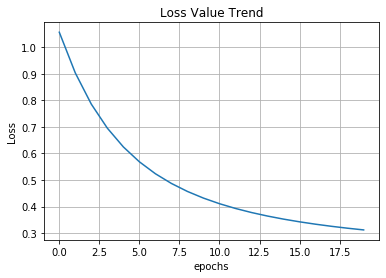

In [8]:
plt.title('Loss Value Trend')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.grid()
plt.plot(loss_val_list)

plt.show()

In [9]:
test_input_data = test_data[ :, 0:-1 ]
test_target_data = test_data[ :, -1 ]

accuracy_ret = obj1.accuracy(test_input_data, test_target_data) 

print('Test Data Accuracy = ', np.round(accuracy_ret, 3))

Test Data Accuracy =  0.784
